## Objective
Run propagation signal algorithm and perform initial analysis

In [20]:
# region Set up notebook imports
%load_ext autoreload
%autoreload
# Allow for imports of other scripts
import sys
PATH = "/data/MEAprojects/PropSignal"
if PATH not in sys.path:
    sys.path.append(PATH)
# Reload a module after changes have been made
from importlib import reload
# endregion

import numpy as np
from pathlib import Path

from sorters import PropSignal

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load spike times
# For 5RMS thresh crossing inputs, check src/analysis/deprecated/si, to rewrite this, rename "get_inputs_from_maxwell" to just "inputs"
SPIKE_TIMES_PATH = Path("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/thresh_crossings_5_neg_only.npy")
##
SPIKE_TIMES = np.load(SPIKE_TIMES_PATH, allow_pickle=True)
##
SPIKE_TIMES = PropSignal.format_thresh_crossings(SPIKE_TIMES)

In [12]:
## Load example spike times
# from scipy.io import loadmat
# SPIKE_TIMES = loadmat("/data/MEAprojects/PropSignal/data/example/example_data.mat")["spike_times"][0, :]
# SPIKE_TIMES = np.array([a[0, :] if a.size > 0 else np.array([]) for a in SPIKE_TIMES], dtype=object)
# spike_times = SPIKE_TIMES

In [4]:
# Convert spike times to milliseconds (None for no conversion, or just don't run the cell)
SAMPLING_FREQ = None  # in kHz
##
if SAMPLING_FREQ is not None:
    spike_times = np.array([st / SAMPLING_FREQ for st in SPIKE_TIMES], dtype=object)
else:
    spike_times = SPIKE_TIMES

In [15]:
%autoreload
from sorters import PropSignal

SAVE_PATH = SPIKE_TIMES_PATH.parent / "versions/1"
ALG_PARAMS_V1 = {
    "thres_freq": 1,
    "seconds_recording": 900,
    "thres_number_spikes": None,
    "ratio": 0.5,
    "thres_cooccurrences": 250,
    "p": 50,

    "small_window": 0.5,
    "big_window": 2,
    "ccg_before": 1.5,
    "ccg_after": 1.5,
    "ccg_n_bins": 91,
}
ALG_PARAMS_V2 = {
    "thresh_freq": 1,
    "seconds_recording": 180,
    "thresh_number_spikes": None,
    "ratio": 0.5,
    "thresh_cooccurrences_num": 50,
    "thresh_cooccurrences_p": 50,
    "p": 50,

    "small_window": 0.5,
    "big_window": 2,
    "ccg_before": 1.5,
    "ccg_after": 1.5,
    "ccg_n_bins": 61,
}
##
prop_signals = PropSignal.run(SAVE_PATH, 1, spike_times, **ALG_PARAMS_V1)

In [16]:
print(f"Num propagations: {len(prop_signals)}")

Num propagations: 51


In [ ]:
test = np.load("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/old_testing/list_of_propagation_final.npy", allow_pickle=True)
len(test)

In [26]:
# Save propagations
ROOT_SAVE_PATH = "/data/MEAprojects/PropSignal/data/example/default"  # Path(SPIKE_TIMES_PATH).parent / "prop_signal/default"
##
path_root = Path(ROOT_SAVE_PATH)
path_root.mkdir(parents=True, exist_ok=False)
np.save(str(path_root / "propagations.npy"), np.array(list_of_propagation, dtype=object))
np.save(str(path_root / "propagating_times.npy"), np.array(propagating_times, dtype=object))
with open(path_root / "params.json", "w") as f:
    json.dump(ALG_PARAMS, f)

## Investigation
Objective: To investigate propagations with plots

In [42]:
# Load propagation data
prop_signals = PropSignal("ROOT_SAVE_PATH", elec_idx=-1)

In [43]:
# Set params needed for most cells
REC_PATH = "/data/MEAprojects/DLSpikeSorter/2950/data.raw.h5"
print(REC_PATH)

/data/MEAprojects/DLSpikeSorter/2950/data.raw.h5


In [ ]:
## Plot individual propagations
# prop_signals.plot_prop(14, REC_PATH)
prop_signals.plot_props_all(REC_PATH,
                            xlim_buffer=200, ylim_buffer=200)

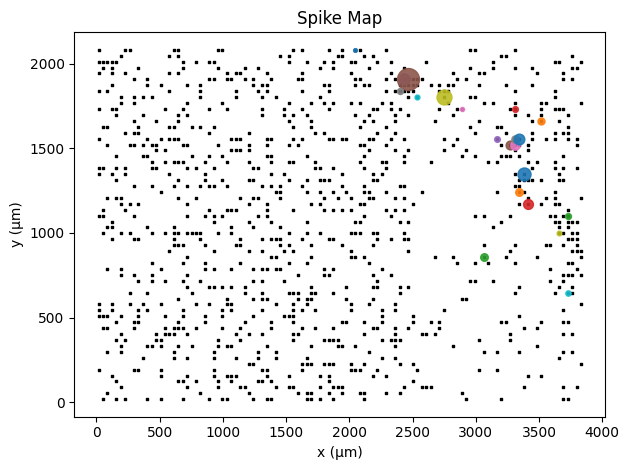

In [25]:
## Plot spikes detected by propagations
prop_signals.plot_activity_map(REC_PATH)

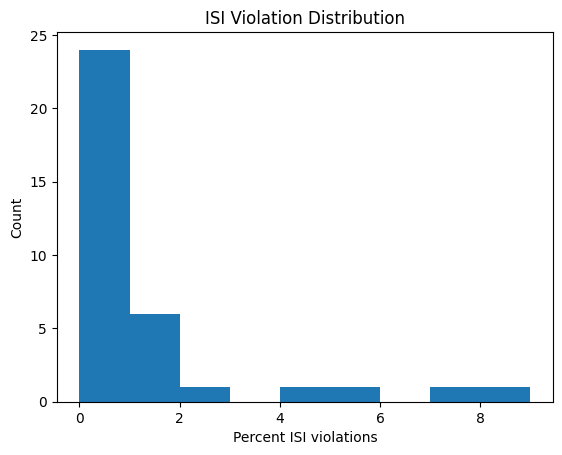

1% ISI Viol Pass/Total: 24/35
[ 0  1  5  6  7  9 10 11 12 13 14 16 17 18 23 24 25 26 27 28 29 30 31 33]


In [13]:
# Plot ISI-violation distribution
CURATE_THRESHOLD = 1  # Max percent of ISI violations for curation
##
%autoreload
isis = prop_signals.plot_isis(bins=range(10))
print(f"{CURATE_THRESHOLD}% ISI Viol Pass/Total: {sum(1 for isi in isis if isi <= CURATE_THRESHOLD)}/{len(isis)}")
print(np.flatnonzero(np.array(isis) <= CURATE_THRESHOLD))